# Mixed vs. Singular Emotion Classification

In [5]:
import numpy as np
import pandas as pd
import os
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import sklearn.metrics
import sklearn.preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import validation_curve

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
np.random.seed(1)

## Data exploratory and visualization

In [9]:
path_label = "data//train_set//label.csv"
train_label = pd.read_csv(path_label)

In [10]:
train_label

,Index,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2995,2996,0
2996,2997,0
2997,2998,0
2998,2999,1


In [11]:
np.unique(train_label['label'])

array([0, 1])

In [12]:
print(train_label[train_label['label'] == 0].shape)
print(train_label[train_label['label'] == 1].shape)

(2402, 2)
(598, 2)


In [13]:
index = np.random.randint(0, 3000)
print(index)
path_imgs = f"data//train_set//images//{index:04d}.jpg"
path_points = f"data//train_set//points//{index:04d}.mat"

1061


In [14]:
# becareful, sometimes the label is different
# try index = 20, the label is 'faceCoordinate2'
mat = scipy.io.loadmat(path_points)['faceCoordinatesUnwarped']

In [15]:
mat.shape

(78, 2)

In [16]:
mat[0]

array([452.58982512, 372.97853736])

In [17]:
img = mpimg.imread(path_imgs)

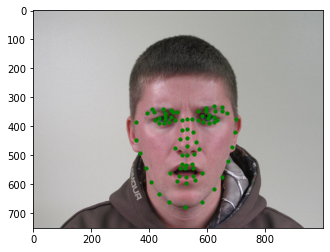

In [18]:
plt.imshow(img)
plt.scatter(mat[:, 0], 
            mat[:, 1],
            c = 'green',
            s = 10,
            alpha = 1
           )
plt.show()

In [19]:
center = np.average(mat, axis=0)

In [20]:
dist = ((mat - center)**2).sum(1)

## Prelim

In [21]:
# import all data into a file
m = 3000
data_points = np.zeros(shape=(m, 78, 2), dtype=np.float)

for i in range(1, m+1):
    # not really what try except is designed for, but works here
    try:
        data_points[i-1] = scipy.io.loadmat(
            f"data//train_set//points//{i:04d}.mat"
        )['faceCoordinatesUnwarped']
    except:
        data_points[i-1] = scipy.io.loadmat(
            f"data//train_set//points//{i:04d}.mat"
        )['faceCoordinates2']       # for index 20

In [22]:
data_points.shape

(3000, 78, 2)

In [23]:
data_points[0][0]

array([495.24811219, 336.71682848])

Splitting train - dev - test by 80 - 10 - 10

In [24]:
data_indices = list(range(3000))

In [25]:
np.random.shuffle(data_indices)

In [26]:
split_1 = int(0.8 * len(data_points))
split_2 = int(0.9 * len(data_points))
train_points = data_points[data_indices[:split_1]]
dev_points = data_points[data_indices[split_1:split_2]]
test_points = data_points[data_indices[split_2:]]

In [27]:
train_label.shape

(3000, 2)

In [28]:
train_Y = np.array(train_label['label'][data_indices[:split_1]])
dev_Y = np.array(train_label['label'][data_indices[split_1:split_2]])
test_Y = np.array(train_label['label'][data_indices[split_2:]])

Check if the split success, the output should be different from the output from data_points[0][0] above

In [29]:
train_points[0][0]

array([401.78212291, 399.0698324 ])

## Process to distance

In [30]:
def convertToDistance(data:np.array, rescale:bool=False) -> np.array:
    m, n, _ = data.shape
    centers = np.average(data, axis=1)
    distances = np.sqrt(
        ((data - 
          np.repeat(centers, n, axis=1).reshape((m, n, 2)))**2).sum(2)
    )
    if rescale:
        return sklearn.preprocessing.minmax_scale(distances.T).T
    return distances

First, we find the rescaled distance to the median of all points

In [31]:
train_distances = convertToDistance(train_points)
train_rescaled = convertToDistance(train_points, rescale=True)

We also need to process the dev set

In [32]:
dev_distances = convertToDistance(dev_points)
dev_rescaled = convertToDistance(dev_points, rescale=True)

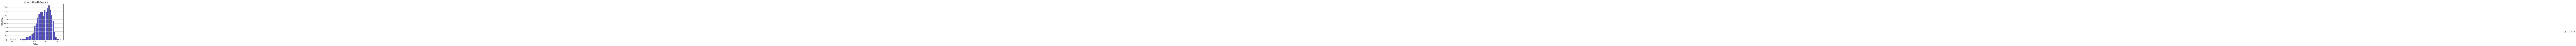

In [33]:
# An "interface" to matplotlib.axes.Axes.hist() method
n_plot, bins, patches = plt.hist(x=train_rescaled[:, 1], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
plt.show()

## Base line model: Logistic Regression

In [29]:
from sklearn import linear_model

In [30]:
print(train_rescaled.shape)
print(train_distances.shape)
print(train_Y.shape)

(2400, 78)
(2400, 78)
(2400,)


In [144]:
clf = linear_model.LogisticRegressionCV(cv=5, random_state=0, max_iter=1000, class_weight='auto').fit(
    train_rescaled, train_Y)

In [145]:
clf.score(train_rescaled, train_Y)

0.825

In [146]:
clf.score(dev_rescaled, dev_Y)

0.82

In [147]:
pred_Y = clf.predict(train_rescaled)

In [148]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    np.array(train_Y), np.array(pred_Y), pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.5976833048224398

In [149]:
# TN FP
# FN TP
sklearn.metrics.confusion_matrix(train_Y, pred_Y)

array([[1875,   44],
       [ 376,  105]])

In [120]:
# TN FP
# FN TP
sklearn.metrics.confusion_matrix(train_Y, pred_Y)

array([[1875,   44],
       [ 376,  105]])

In [143]:
# TN FP
# FN TP
sklearn.metrics.confusion_matrix(train_Y, pred_Y)

array([[1390,  529],
       [ 134,  347]])

In [84]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [85]:
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(random_state=0), train_rescaled, train_Y, cv=5
)

In [89]:
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB

from sklearn.datasets import load_digits

from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

In [90]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

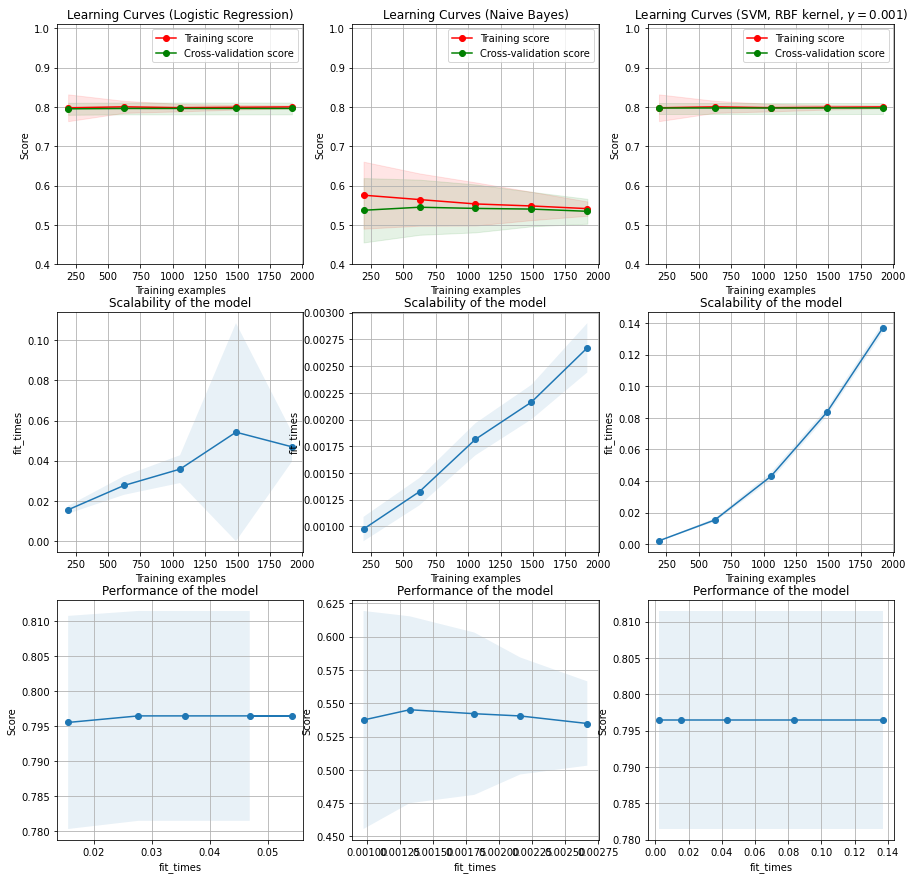

In [91]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

X, y = train_rescaled, train_Y

title = r"Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.4, 1.01),
                    cv=cv)

title = r"Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.4, 1.01),
                    cv=cv)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.4, 1.01),
                    cv=cv)

plt.show()

In [93]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X, y)

In [95]:
print(clf_tree.score(X, y))

print(clf_tree.score(dev_rescaled, dev_Y))

pred_Y = clf.predict(train_rescaled)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    np.array(train_Y), np.array(pred_Y), pos_label=1)
sklearn.metrics.auc(fpr, tpr)

1.0
0.7066666666666667


0.5

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
clf_bt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=1, random_state=0).fit(X, y)
print(clf_bt.score(X, y))

print(clf_bt.score(dev_rescaled, dev_Y))

pred_Y = clf_bt.predict(train_rescaled)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    np.array(train_Y), np.array(pred_Y), pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.84
0.7966666666666666


0.617968471538039

In [98]:
clf_bt.feature_importances_

array([0.        , 0.        , 0.0079161 , 0.        , 0.        ,
       0.01789797, 0.        , 0.00631446, 0.00456842, 0.01160291,
       0.00715415, 0.        , 0.01219766, 0.04331868, 0.00823765,
       0.        , 0.02091187, 0.        , 0.        , 0.02890901,
       0.03012261, 0.00488571, 0.        , 0.        , 0.00896971,
       0.        , 0.        , 0.00523513, 0.0059308 , 0.069271  ,
       0.02441696, 0.01180485, 0.        , 0.        , 0.        ,
       0.        , 0.00622444, 0.        , 0.00440398, 0.01048627,
       0.        , 0.00625219, 0.0192761 , 0.01895721, 0.03784638,
       0.        , 0.00441508, 0.04285123, 0.00982727, 0.07493578,
       0.03705238, 0.04385091, 0.        , 0.        , 0.05572374,
       0.04657047, 0.03521249, 0.00533079, 0.02266336, 0.01816295,
       0.03139698, 0.        , 0.03009772, 0.01079013, 0.        ,
       0.        , 0.01735064, 0.00702375, 0.        , 0.00738733,
       0.01717235, 0.00952999, 0.00940734, 0.00921179, 0.00822

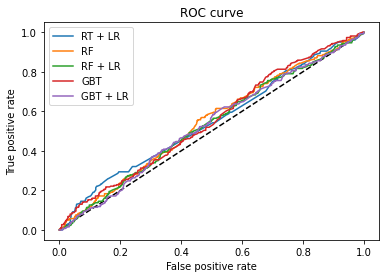

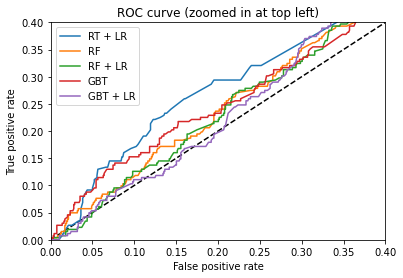

In [103]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
                          random_state=0)

rt_lm = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [127]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

In [126]:
clf = linear_model.LogisticRegressionCV(cv=5, random_state=0, max_iter=1000, class_weight=class_weights).fit(
    train_rescaled, train_Y)

clf.score(train_rescaled, train_Y)

clf.score(dev_rescaled, dev_Y)

pred_Y = clf.predict(train_rescaled)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    np.array(train_Y), np.array(pred_Y), pos_label=1)
sklearn.metrics.auc(fpr, tpr)

# TN FP
# FN TP
sklearn.metrics.confusion_matrix(train_Y, pred_Y)

array([[1875,   44],
       [ 376,  105]])

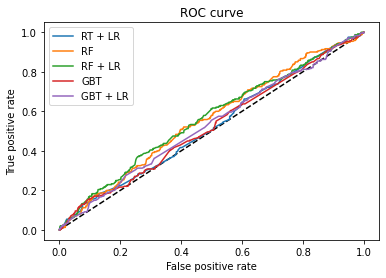

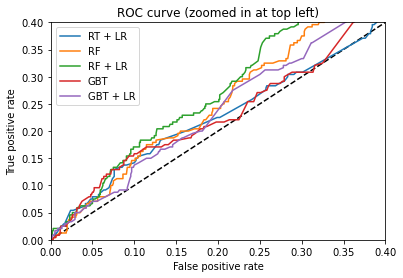

In [134]:
n_estimator = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
                          random_state=0)

rt_lm = LogisticRegression(max_iter=1000, class_weight='balanced')
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, class_weight='balanced')
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000, class_weight='balanced')
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000, class_weight='balanced')
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [2]:
import xgboost as xgb

In [3]:
from sklearn.metrics import mean_squared_error

In [34]:
from sklearn.model_selection import train_test_split
X, y = train_rescaled, train_Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [38]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [39]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

0.4188614240418417

In [43]:
xg_reg.score(train_rescaled, train_Y)

-0.05380873537364961

In [44]:
xg_reg.score(dev_rescaled, dev_Y)

-0.09515399019221493

In [47]:
pred_Y = xg_reg.predict(train_rescaled)

In [50]:
pred_Y = xg_reg.predict(train_rescaled)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    np.array(train_Y), np.array(pred_Y), pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.6266533700092846

In [52]:
train_Y

array([0, 0, 1, ..., 0, 0, 0])

In [53]:
pred_Y

array([0.30900985, 0.29556593, 0.31332523, ..., 0.31361717, 0.2998813 ,
       0.3143829 ], dtype=float32)

In [55]:
model = xgb.XGBClassifier()

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.67562


In [64]:
model = xgb.XGBClassifier(scale_pos_weight=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.67284


In [67]:
from sklearn.model_selection import GridSearchCV
# define grid
weights = [1, 3, 5, 10, 20, 50, 100]
param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid.fit(X, y)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[12:39:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.681524 using {'scale_pos_weight': 3}
0.675623 (0.036677) with: {'scale_pos_weight': 1}
0.681524 (0.032704) with: {'scale_pos_weight': 3}
0.672845 (0.036342) with: {'scale_pos_weight': 5}
0.672298 (0.036273) with: {'scale_pos_weight': 10}
0.673096 (0.030338) with: {'scale_pos_weight': 20}
0.659340 (0.040742) with: {'scale_pos_weight': 50}
0.646141 (0.044411) with: {'scale_pos_weight': 100}
